In [201]:
# Read hessian matrix and atomic masses/coordinates from Gaussian09 output file
# compute vibrational frequencies

In [202]:
from qm_subs import *
from chem_subs import *
import re
import pandas as pd
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)

In [203]:
def hess2freq(hess, mass3, invmass=False, unweight=True):
    # given a hessian (in atomic units) and a cartesian mass vector (in amu),
    #    return the harmonic vibrational frequencies (cm**-1) and mode vectors
    # 'invmass' means that instead of cartesian masses we have cartesian
    #    inverse-square-root masses (in units of amu**-0.5)
    # 'unweight' causes mass weights to be removed from eigenvectors, 
    #    which are then renormalized
    #
    # convert masses from amu to atomic units
    if not invmass:
        mass3 = mass3 * AMU_AU
        # inverse mass weights
        alpha3 = mass3 ** -0.5
    else:
        alpha3 = mass3 * (AMU_AU ** -0.5)
    amat = np.outer(alpha3, alpha3)
    # mass-weighted hessian
    mhess = np.multiply(hess, amat)
    vals, vecs = np.linalg.eigh(mhess)
    # return imaginary freqs as negative reals
    freqs = np.sqrt(np.abs(vals)) * np.sign(vals)
    # freqs start with units = atomic unit of inverse of time = hbar/Eh
    freqs = freqs * AU_JOULE / HBAR
    # now freqs should be in s-1
    # convert to cm-1 and from angular to periodic
    freqs = freqs / (CLIGHT * 100) / (2 * np.pi)
    if unweight:
        # remove inverse mass weights from eigenvectors
        mvecs = np.divide(vecs, amat)
        # normalize rows
        nrms = np.linalg.norm(mvecs, axis=1)
        mvecs = mvecs / nrms
        return freqs, mvecs
    else:
        return freqs, vecs

In [204]:
def termin_mass_scale(Geom, hess, minv3, A=0.040):
    # directional mass-weighting of terminal atoms
    # return vibrational frequencies (in cm**-1) and mode vectors
    # Special treatment for terminal atoms bonded together
    #
    # find the terminal atoms and their normalized bond vectors
    print('aaaaa minv3 = ', minv3)
    terminal = []
    bvec = []
    blist = Geom.bonded_list()
    for i in range(len(blist)):
        if len(blist[i]) == 1:
            # this is a terminal atom
            terminal.append(i)
            bvec.append(Geom.vec(i, blist[i][0], 1.0))
        else:
            bvec.append([])
    print('aaaa  terminal = ', terminal)
    # scale each cartesian component according to its bond-vector component
    minv = minv3.reshape(-1,3).copy()
    for iatom in terminal:
        beta = 1.
        print('aaaa blist[{:d}][0] = {:d}'.format(iatom, blist[iatom][0]))
        if blist[iatom][0] in terminal:
            # it is bonded to another terminal atom; find which is heavier
            beta = (minv3[3*iatom] / minv3[3*blist[iatom][0]])**2
            if beta < 1:
                # this atom is heavier; don't scale
                continue
            else:
                # adjust scaling paramater
                beta = np.sqrt((beta + 1)/beta)
                print('aaaa  beta = {:.4f}'.format(beta))
        for j in [0, 1, 2]:
            mu = minv[iatom, j]
            minv[iatom, j] = mu - A * beta * abs(bvec[iatom][j]) / (mu * mu)
    minv = minv.flatten()
    freqs, vecs = hess2freq(hess, minv, invmass=True)
    return freqs, vecs

In [205]:
molec = 'h2o'
linear = False

In [206]:
# experimental fundamentals for water, from CCCBDB
expt = {'h2o': np.array([1595., 3657., 3756.]),  # Shimanouchi
        'hdo': np.array([1402., 2727., 3707.]),  # Shimanouchi
        'd2o': np.array([1178., 2671., 2788.]),  # Shimanouchi
        'h2' : np.array([4161.16632]),  # G.D. Dickenson et al.
        'hd' : np.array([3632.16054]),  # G.D. Dickenson et al.
        'd2' : np.array([2993.61713]),  # G.D. Dickenson et al.
}

In [207]:
# get the frequencies as computed by Gaussian
fgau = '{:s}_freq.out'.format(molec)
regx = re.compile('Frequ')
gaufreqs = []
with open(fgau) as f:
    for line in f:
        if regx.search(line):
            fields = line.split()
            gaufreqs.extend(fields[2:])
gaufreqs = np.array(gaufreqs, dtype=float)

In [208]:
# get the initial geometry
Geom = read_qm_Geometry('gaussian09', fgau)[0]
print(Geom.bonded_list())

[array([1, 2]), array([0]), array([0])]


In [209]:
masses = np.array(read_g09_atom_masses(fgau))
Geom.set_masses(masses)
mass3 = Geom.massVector(tripled=True)
rotconst, moment, axes = Geom.rotational()

In [210]:
print(rotconst)
print('nonzero:', np.nonzero(moment))
print('where:', len(np.where(moment<=0)[0]))

[ 808.93315538  435.53260331  283.10683569]
nonzero: (array([0, 1, 2]),)
where: 0


In [211]:
arch = read_g09_archive_block(fgau)
arch = parse_g09_archive_block(arch)

In [212]:
minv3 = mass3 ** -0.5
freqs, mvecs = hess2freq(arch['hessian'], minv3, invmass=True)

In [213]:
if linear:
    nfreq = len(mass3) - 5
else:
    nfreq = len(mass3) - 6

In [214]:
freqs[-nfreq:]

array([ 1645.52747592,  3810.55183195,  3919.7300543 ])

In [215]:
results = pd.DataFrame(np.array([expt[molec], freqs[-nfreq:], gaufreqs]).T, 
        columns = ['expt', 'this', 'G09'])
results

,expt,this,G09
0,1595.0,1645.527476,1645.5307
1,3657.0,3810.551832,3810.5608
2,3756.0,3919.730054,3919.7389


In [216]:
freqs, vecs = termin_mass_scale(Geom, arch['hessian'], minv3, A=0.040)
results = pd.DataFrame(np.array([expt[molec], freqs[-nfreq:], gaufreqs]).T, 
        columns = ['expt', 'this', 'G09'])
results

aaaaa minv3 =  [ 0.25003978  0.25003978  0.25003978  0.99610784  0.99610784  0.99610784
  0.99610784  0.99610784  0.99610784]
aaaa  terminal =  [1, 2]
aaaa blist[1][0] = 0
aaaa blist[2][0] = 0


,expt,this,G09
0,1595.0,1636.459365,1645.5307
1,3657.0,3669.790194,3810.5608
2,3756.0,3778.735952,3919.7389


In [220]:
# generate A-dependence for plotting
Avals = np.arange(0.03, 0.05, 0.0002)
freqs = []
for A in Avals:
    f, v = termin_mass_scale(Geom, arch['hessian'], minv3, A=A)
    freqs.append(f[-nfreq:])
freqs = np.array(freqs)

aaaaa minv3 =  [ 0.25003978  0.25003978  0.25003978  0.99610784  0.99610784  0.99610784
  0.99610784  0.99610784  0.99610784]
aaaa  terminal =  [1, 2]
aaaa blist[1][0] = 0
aaaa blist[2][0] = 0
aaaaa minv3 =  [ 0.25003978  0.25003978  0.25003978  0.99610784  0.99610784  0.99610784
  0.99610784  0.99610784  0.99610784]
aaaa  terminal =  [1, 2]
aaaa blist[1][0] = 0
aaaa blist[2][0] = 0
aaaaa minv3 =  [ 0.25003978  0.25003978  0.25003978  0.99610784  0.99610784  0.99610784
  0.99610784  0.99610784  0.99610784]
aaaa  terminal =  [1, 2]
aaaa blist[1][0] = 0
aaaa blist[2][0] = 0
aaaaa minv3 =  [ 0.25003978  0.25003978  0.25003978  0.99610784  0.99610784  0.99610784
  0.99610784  0.99610784  0.99610784]
aaaa  terminal =  [1, 2]
aaaa blist[1][0] = 0
aaaa blist[2][0] = 0
aaaaa minv3 =  [ 0.25003978  0.25003978  0.25003978  0.99610784  0.99610784  0.99610784
  0.99610784  0.99610784  0.99610784]
aaaa  terminal =  [1, 2]
aaaa blist[1][0] = 0
aaaa blist[2][0] = 0
aaaaa minv3 =  [ 0.25003978  0.2500

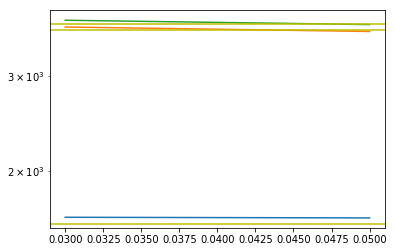

In [221]:
plt.semilogy(Avals, freqs)
for xfreq in expt[molec]:
    plt.axhline(y=xfreq, color='y', linestyle='-')
#plt.rcParams["figure.figsize"] = [10, 16]
plt.savefig('hessian_freqs.png')
plt.show()

In [222]:
c = np.zeros((freqs.shape[0], freqs.shape[1]+1))
c[:, 0] = Avals
c[:, 1:] = freqs - expt[molec]
print(c)

[[  0.03        43.73436207  48.01189269  57.86085693]
 [  0.0302      43.68891736  47.30766202  57.15753419]
 [  0.0304      43.64347043  46.60342302  56.45424489]
 [  0.0306      43.59802129  45.8991757   55.75098906]
 [  0.0308      43.55256994  45.19492005  55.0477667 ]
 [  0.031       43.50711636  44.49065608  54.34457782]
 [  0.0312      43.46166056  43.78638379  53.64142244]
 [  0.0314      43.41620254  43.08210318  52.93830058]
 [  0.0316      43.37074229  42.37781425  52.23521224]
 [  0.0318      43.32527981  41.67351701  51.53215745]
 [  0.032       43.2798151   40.96921146  50.8291362 ]
 [  0.0322      43.23434815  40.26489759  50.12614852]
 [  0.0324      43.18887896  39.56057541  49.42319442]
 [  0.0326      43.14340754  38.85624492  48.72027392]
 [  0.0328      43.09793387  38.15190613  48.01738702]
 [  0.033       43.05245795  37.44755903  47.31453374]
 [  0.0332      43.00697979  36.74320363  46.6117141 ]
 [  0.0334      42.96149937  36.03883993  45.9089281 ]
 [  0.0336